In [1]:
import numpy as np
import matplotlib.pyplot as plt

import SMBHBpy
from SMBHBpy import constants as c
from SMBHBpy import merger_system as ms

### Define the SMBH binary
The code works in geometrized units with $c=G=1$. All units are converted to parsecs (pc) before use, using the conversion factors included in constants.py.

In [15]:
m1 =  1.0*1e8 * c.solar_mass_to_pc             # The mass of the first SMBH
m2 =  1.0*1e8 * c.solar_mass_to_pc             # The mass of the second SMBH

D_luminosity = 1e8                             # The (measured) distance to the system from earth [pc]

sigma = 200 *10**3*c.m_to_pc/(c.s_to_pc)       # Velocity dispersion of the host galaxy-bulge
b_max = 10  *10**3                             # Maximum impact parameter for calculating the Coulomb logarithm
H = 18                                         # Factor of the hardening rate/mechanism (H = 15-20, H=18 for hard binary, determined from scattering experiments)
rho_hardening = 1e0 * c.solar_mass_to_pc       # Density for hardening rate (has to be constant / independent of r/a!, otherwise a code adjustment is necessary within "inspiral!")

# k: Indicates whether the halos are static (k = 0) or non-static, i.e. rotating (k=1), 
# k = 0 can be selected independently of the eccentricity e, k = 1 only if circular orbits (e=0) are involved.
k = 0.

### Define the dark matter spike properties

In [16]:
# Define a cold dark matter spike around each SMBH
# https://arxiv.org/pdf/1408.3534.pdf

r_sp_1 = 0.2*m1/sigma**2
r_sp_2 = 0.2*m2/sigma**2

alpha_1 = 7./3.
alpha_2 = 7./3.

rho_sp_1 = (3-alpha_1)*0.2**(3-alpha_1)*m1/(2*np.pi*r_sp_1**3)
rho_sp_2 = (3-alpha_2)*0.2**(3-alpha_2)*m2/(2*np.pi*r_sp_2**3)

spike_1 = SMBHBpy.halo.Spike(rho_sp_1, r_sp_1, alpha_1)
spike_2 = SMBHBpy.halo.Spike(rho_sp_2, r_sp_2, alpha_2)

# For GW-only, i.e. without spikes around the SMBHs, for comparison
spike_1_GW = SMBHBpy.halo.Spike(0., r_sp_1, alpha_1)
spike_2_GW = SMBHBpy.halo.Spike(0., r_sp_2, alpha_2)

# Constant Matter Halo
const_halo1 = SMBHBpy.halo.ConstHalo(rho_hardening)
const_halo2 = SMBHBpy.halo.ConstHalo(rho_hardening)

### Define initial conditions for a circular inspiral

In [29]:
# Create the SystemProp object describing the SMBH binary with DM spikes
sp = ms.SystemProp(m1, m2, spike_1, spike_2, sigma, b_max, k, 0., 0., D=D_luminosity, inclination_angle = np.pi/2)

# Create the SystemProp object describing the SMBH binary without DM spikes + hardening mechanism
sp_hard = ms.SystemProp(m1, m2, spike_1_GW, spike_2_GW, sigma, b_max, k, H, rho_hardening, D=D_luminosity, inclination_angle = np.pi/2) 

# Create the SystemProp object describing the SMBH binary with DM spikes + hardening mechanism
sp_hard_spikes = ms.SystemProp(m1, m2, spike_1, spike_2, sigma, b_max, k, H, rho_hardening, D=D_luminosity, inclination_angle = np.pi/2)

# Create the SystemProp object describing the SMBH binary with const. halo + hardening mechanism
sp_hard_const_halo = ms.SystemProp(m1, m2, const_halo1, const_halo2, sigma, b_max, k, H, rho_hardening, D=D_luminosity, inclination_angle = np.pi/2)

# Create the SystemProp object describing the SMBH binary with DM spikes + relativistic corrections to dynamical friction
#sp_rel = ms.SystemProp(m1, m2, spike_1, spike_2, sigma, b_max, k, 0, 0, D=D_luminosity, inclination_angle = np.pi/2, relcorr = True)

# For GW-only, i.e. without spikes around the SMBHs, for comparison
sp_GW = ms.SystemProp(m1, m2, spike_1_GW, spike_2_GW, sigma, b_max, k, 0,0, D=D_luminosity, inclination_angle = np.pi/2)


#R0 = 50 * (sp.r_isco_1()+sp.r_isco_2())      # Initial separation
R0 = 0.06
#R_fin = sp.r_isco_1()+sp.r_isco_2()          # The final condition for the evolution
R_fin = 0.0045

f_ini = 1./(1+sp.z())*1./np.pi*np.sqrt(sp.m_total()/R0**3)/c.hz_to_invpc
f_final = 1./(1+sp.z())*1./np.pi*np.sqrt(sp.m_total()/R_fin**3)/c.hz_to_invpc

print("f_initial = ", f_ini, "Hz")
print("f_final =   ",f_final,"Hz")

f_initial =  6.374819020574985e-10 Hz
f_final =    3.103673046739475e-08 Hz


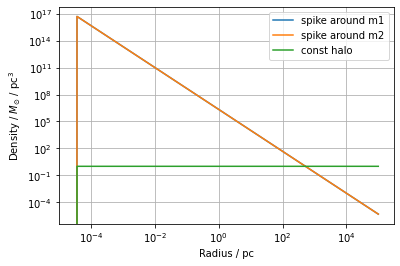

In [30]:
# Plot density distributions
r_grid1 = np.geomspace(sp.r_isco_1(), 1e5, 100) 
r_grid2 = np.geomspace(sp.r_isco_2(), 1e5, 100)
plt.loglog(r_grid1, spike_1.density(r_grid1)/c.solar_mass_to_pc, label='spike around m1')
plt.loglog(r_grid2, spike_2.density(r_grid2)/c.solar_mass_to_pc, label='spike around m2')
plt.loglog(r_grid2, const_halo1.density(r_grid2)/c.solar_mass_to_pc, label='const halo')
plt.grid(); plt.xlabel("Radius / pc"); plt.ylabel("Density / $M_{\odot}$ / pc$^3$"); plt.legend(); plt.show()

### Solve the differential equations

In [31]:
# Solve the differential equations for DM spikes
ev = SMBHBpy.inspiral.Classic.Evolve(sp, R0, a_fin = R_fin)

# Solve the differential equations for without DM spikes + hardening mechanism
ev_hard = SMBHBpy.inspiral.Classic.Evolve(sp_hard, R0, a_fin = R_fin)

# Solve the differential equations for "with DM spikes + hardening mechanism"
ev_hard_spikes = SMBHBpy.inspiral.Classic.Evolve(sp_hard_spikes, R0, a_fin = R_fin)

# Solve the differential equations for "const. halos + hardening mechanism"
ev_hard_const_halo = SMBHBpy.inspiral.Classic.Evolve(sp_hard_const_halo, R0, a_fin = R_fin)

# Solve the differential equations for DM spikes + relativistic corrections to dynamical friction
ev_rel = SMBHBpy.inspiral.Classic.Evolve(sp_rel, R0, a_fin = R_fin)

# For GW-only, i.e. without spikes around the SMBHs, for comparison
ev_GW = SMBHBpy.inspiral.Classic.Evolve(sp_GW, R0, a_fin = R_fin)

Evolving from  1041.6666666666667  to  78.125 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-42
A termination event occurred.
 -> Evolution took 0.1982s
Evolving from  1041.6666666666667  to  78.125 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-42


C:\Users\matthias\Anaconda\lib\site-packages\scipy\integrate\_ivp\common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


A termination event occurred.
 -> Evolution took 0.7156s
Evolving from  1041.6666666666667  to  78.125 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-42
A termination event occurred.
 -> Evolution took 0.1609s
Evolving from  1041.6666666666667  to  78.125 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-42
A termination event occurred.
 -> Evolution took 0.8475s
Evolving from  1041.6666666666667  to  78.125 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-42
A termination event occurred.
 -> Evolution took 0.2392s
Evolving from  1041.6666666666667  to  78.125 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-42
A termination event occurred.
 -> Evolution took 0.8764s


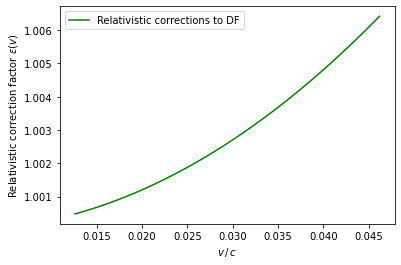

In [32]:
# Relativistic corrections to dynamical friction during the hole inspiral
v = np.sqrt(sp.m_total()/ev.R)
epsilon_v = 1./(1-v**2) * (1+v**2)**2
plt.plot(v,epsilon_v, label = "Relativistic corrections to DF", color = "green")
plt.xlabel("$v\,/\,c$"); plt.ylabel("Relativistic correction factor $\u03B5(v)$"); plt.legend()
plt.show()

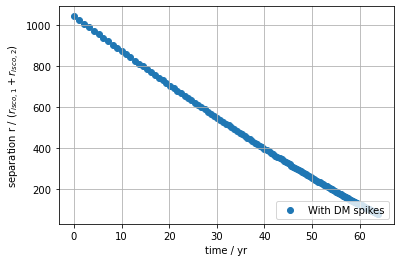

146

In [43]:
# Plot the results for the temporal evolution of the distance r between the SMBHs
plt.loglog(ev.t/c.year_to_pc, ev.R/(sp.r_isco_1()+sp.r_isco_2()), label = "With DM spikes")
#plt.loglog(ev_rel.t/c.year_to_pc, ev_rel.R/(sp.r_isco_1()+sp.r_isco_2()), label = "With DM spikes + rel. corr. to DF")
plt.loglog(ev_GW.t/c.year_to_pc, ev_GW.R/(sp.r_isco_1()+sp.r_isco_2()), label = "Without DM spikes")
plt.loglog(ev_hard.t/c.year_to_pc, ev_hard.R/(sp.r_isco_1()+sp.r_isco_2()), label = "Without DM spikes + hardening mechanism")
plt.loglog(ev_hard_spikes.t/c.year_to_pc, ev_hard_spikes.R/(sp.r_isco_1()+sp.r_isco_2()), label = "With DM spikes + hardening mechanism")
plt.loglog(ev_hard_const_halo.t/c.year_to_pc, ev_hard_const_halo.R/(sp.r_isco_1()+sp.r_isco_2()), label = "With Const. Halos + hardening mechanism")
plt.grid(); plt.legend(loc = "lower right"); plt.xlabel("time / yr"); plt.ylabel("separation r / ($r_{isco,1}+r_{isco,2}$)"); plt.show()

In [34]:
# final time:
print("Time to coalescence (GW-only):", 5./256.*R_fin**4/(sp.m_total()**2)/sp.m_reduced()/c.year_to_pc*365.25, "days")

# Total evolution time in days with DM spikes:
print("With DM spikes:", ev.t[-1]/c.year_to_pc, "years")

print("Without DM spikes + hardening mechanism:", ev_hard.t[-1]/c.year_to_pc, "years")

print("With Const. Halos + hardening mechanism:", ev_hard_const_halo.t[-1]/c.year_to_pc,  "years = ", ev_hard_const_halo.t[-1]/c.year_to_pc/(13.8*1e9), "T_universe")

print("With DM spikes + hardening mechanism:", ev_hard_spikes.t[-1]/c.year_to_pc, "years")

# Total evolution time in days with DM spikes + relativistic corrections to DF:
print("With DM spikes + rel. corr. to DF:", ev_rel.t[-1]/c.year_to_pc,"years","(",ev_rel.t[-1]/ev.t[-1],"%)")

# Total evolution time in years (GW-only):
print("Without DM spikes:", ev_GW.t[-1]/c.year_to_pc, "years = ", ev_GW.t[-1]/c.year_to_pc/(13.8*1e9), "T_universe")

#
print("GW-only/(Const_halo+hardening mechanism)",ev_GW.t[-1]/ev_hard_const_halo.t[-1])

Time to coalescence (GW-only): 43164612.84695965 days
With DM spikes: 63.935303288124345 years
Without DM spikes + hardening mechanism: 3251775383.652696 years
With Const. Halos + hardening mechanism: 3094748076.7350755 years =  0.22425710700978807 T_universe
With DM spikes + hardening mechanism: 63.935303255761625 years
With DM spikes + rel. corr. to DF: 63.84177216013635 years ( 0.9985370972971459 %)
Without DM spikes: 3734898726.716188 years =  0.270644835269289 T_universe
GW-only/(Const_halo+hardening mechanism) 1.206850649587111


### Calculate the gravitational wave signal

In [40]:
n = 10
R0 = 1
R_fin = sp.r_isco_1()+sp.r_isco_2()
rho_0 = np.linspace(1e-5*c.solar_mass_to_pc, 2*1e1*c.solar_mass_to_pc, n)

const_halo_list = []
sp_list = []
ev_list = []
tot_ev_time_list = []

for i in range(n):
    const_halo_list.append(SMBHBpy.halo.ConstHalo(rho_0[i]))
    sp_list.append(ms.SystemProp(m1, m2, const_halo_list[i], const_halo_list[i], sigma, b_max, k, H, rho_0[i], D=D_luminosity, inclination_angle = np.pi/2))
    ev_list.append(SMBHBpy.inspiral.Classic.Evolve(sp_list[i], R0, a_fin = R_fin))
    tot_ev_time_list.append(ev_list[i].t[-1]/c.year_to_pc)

Evolving from  17361.111111111113  to  1.0 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-42


C:\Users\matthias\Anaconda\lib\site-packages\scipy\integrate\_ivp\common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


Required step size is less than spacing between numbers.
 -> Evolution took 2.1334s
Evolving from  17361.111111111113  to  1.0 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-42


C:\Users\matthias\0-BA\SMBHBs-GitHub\examples\SMBHBpy\inspiral\forces.py:20: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt(sp.m_total() *(2./r - 1./a))


A termination event occurred.
 -> Evolution took 3.1485s
Evolving from  17361.111111111113  to  1.0 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-42


ValueError: `ts` must be strictly increasing or decreasing.

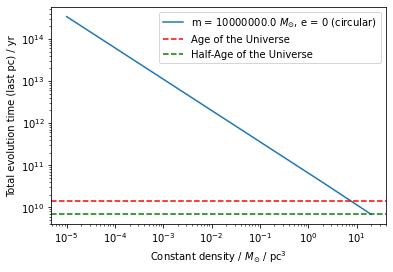

[338222162150326.3,
 36037561825.65134,
 21342927838.666664,
 15703986005.196375,
 12629853080.53672,
 10665222474.235027,
 9288538747.783731,
 8263804354.336621,
 7467740645.593375,
 6829292706.892125]

In [12]:
plt.loglog(rho_0/c.solar_mass_to_pc,tot_ev_time_list, label = "m = " + str(m1/c.solar_mass_to_pc) + ' $M_{\odot}$, e = 0 (circular)') #(m < 10^7 works, accuracy = 10^-20)
plt.axhline(y=13.8*1e9, color='red', linestyle='--', label='Age of the Universe')
plt.axhline(y=13.8*1e9/2, color='green', linestyle='--', label='Half-Age of the Universe')
plt.xlabel('Constant density / $M_{\odot}$ / pc$^3$'); plt.ylabel('Total evolution time (last pc) / yr'); plt.legend(); plt.show()
tot_ev_time_list

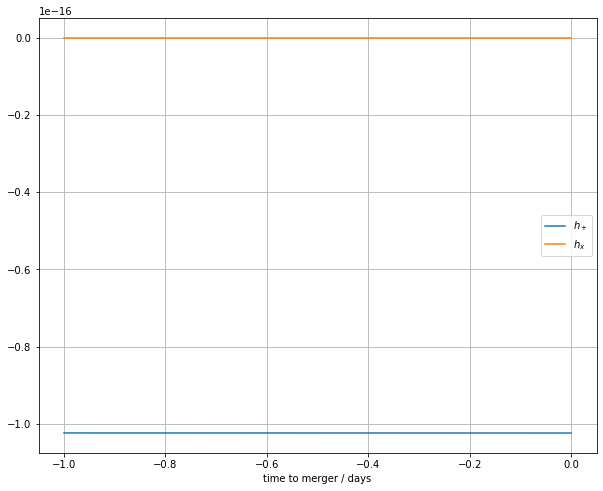

In [23]:
# The gravitational wave signal right before coalescence
tom = ev.t[-1]                                             # time of "merger"
t_grid = np.linspace(tom - 24*3600.*c.s_to_pc, tom, 500)   # Look at the last 1 day of inspiral
h_plus, h_cross = SMBHBpy.waveform.h(sp, ev, t_grid)

plt.figure(figsize=(10,8))
plt.plot((t_grid - tom)/(c.s_to_pc*24*3600), h_plus, label="$h_+$")
plt.plot((t_grid - tom)/(c.s_to_pc*24*3600), h_cross, label="$h_x$")
plt.grid(); plt.legend(); plt.xlabel("time to merger / days"); plt.show()

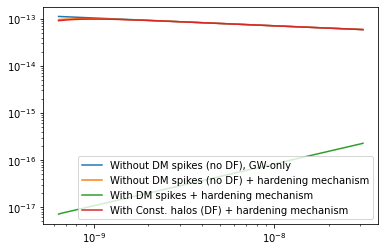

In [39]:
# The characteristic strain of the signal with DM spikes
f_gw, h_2_plus, h_2_cross, psi = SMBHBpy.waveform.h_2(sp, ev)
#plt.loglog(f_gw/c.hz_to_invpc, 2.* f_gw*h_2_plus, label="With DM spikes")

# For GW-only, i.e. without spikes around the SMBHs, for comparison
f_gw_GW, h_2_plus_GW, h_2_cross_GW, psi_GW = SMBHBpy.waveform.h_2(sp_GW, ev_GW)
plt.loglog(f_gw_GW/c.hz_to_invpc, 2.* f_gw_GW*h_2_plus_GW, label="Without DM spikes (no DF), GW-only")

# GW-only + hardening mechanism
f_gw_hard, h_2_plus_hard, h_2_cross_hard, psi_hard = SMBHBpy.waveform.h_2(sp_hard, ev_hard)
#plt.loglog(f_gw_hard/c.hz_to_invpc, 2.* f_gw_hard*h_2_plus_hard, label="Without DM spikes (no DF) + hardening mechanism")

# DM spikes + hardening mechanism
f_gw_hard_spikes, h_2_plus_hard_spikes, h_2_cross_hard_spikes, psi_hard = SMBHBpy.waveform.h_2(sp_hard_spikes, ev_hard_spikes)
plt.loglog(f_gw_hard_spikes/c.hz_to_invpc, 2.* f_gw_hard_spikes*h_2_plus_hard_spikes, label="With DM spikes + hardening mechanism")

# Const halos + hardening mechanism
f_gw_hard_const_halo, h_2_plus_hard_const_halo, h_2_cross_hard_const_halo, psi_hard = SMBHBpy.waveform.h_2(sp_hard_const_halo, ev_hard_const_halo)
plt.loglog(f_gw_hard_const_halo/c.hz_to_invpc, 2.* f_gw_hard_const_halo*h_2_plus_hard_const_halo, label="With Const. halos (DF) + hardening mechanism")

# LISA:
#Lisa = SMBHBpy.detector.Lisa()
#f_gw = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 100)
#plt.loglog(f_gw/c.hz_to_invpc, Lisa.NoiseStrain(f_gw), label='LISA')

plt.legend(loc = "lower right")
plt.show()

### Do the same for an eccentric inspiral

In [25]:
a0 = 50. * (sp.r_isco_1()+sp.r_isco_2())          # initial semi-major axis
e0 = 0.5                                         # initial eccentricity

afin = (sp.r_isco_1()+sp.r_isco_2())             # final condition for a

# Solve the differential equations
sp_ecc = ms.SystemProp(m1, m2, spike_1, spike_2, sigma, b_max, k, 0., 0., D=D_luminosity, inclination_angle = np.pi/2)
ev_ecc = SMBHBpy.inspiral.Classic.Evolve(sp_ecc, a0, e_0=e0,  a_fin = afin)

Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.5  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-42


C:\Users\matthias\Anaconda\lib\site-packages\scipy\integrate\_ivp\common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


A termination event occurred.
 -> Evolution took 44.1825s


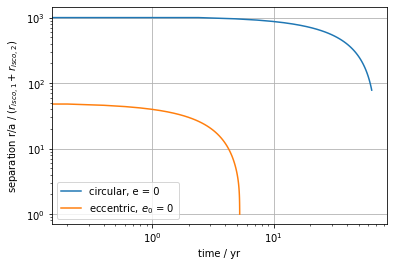

In [54]:
# Plot the results and compare to the circular case
plt.loglog(ev.t/c.year_to_pc,  ev.R/(sp.r_isco_1()+sp.r_isco_2()), label='circular, e = 0')
plt.loglog(ev_ecc.t/c.year_to_pc,  ev_ecc.a/(sp.r_isco_1()+sp.r_isco_2()), label='eccentric, $e_0$ = '+str(e0))
plt.grid(); plt.legend(); plt.xlabel("time / yr"); plt.ylabel("separation r/a / $(r_{isco,1}+r_{isco,2})$"); plt.show()

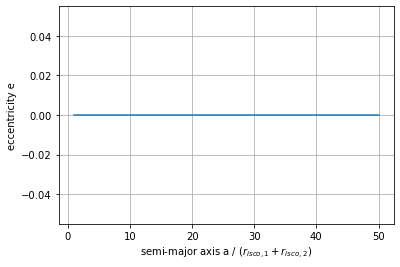

In [55]:
# Plot eccentricity vs. semimajor axis
plt.plot(ev_ecc.a/(sp.r_isco_1()+sp.r_isco_2()), ev_ecc.e)
plt.grid(); plt.xlabel("semi-major axis a / $(r_{isco,1}+r_{isco,2})$"); plt.ylabel("eccentricity e"); plt.show()

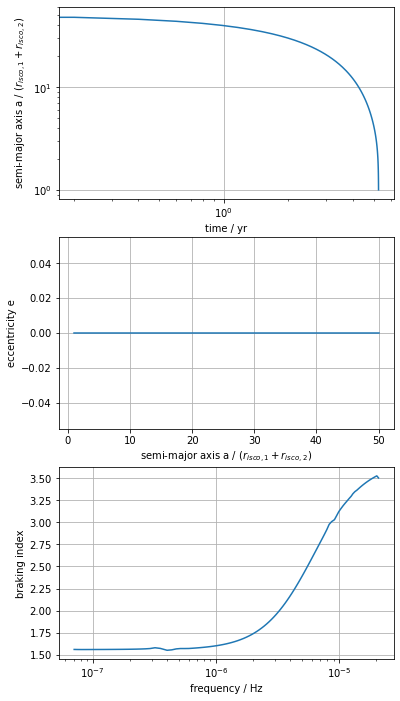

In [56]:
# Alternatively use the plot_utils
fig, axes = plt.subplots(3,1, figsize=(6, 12))
SMBHBpy.plot_utils.plotEvolution(sp, ev_ecc, ax_a=axes[0], ax_ae=axes[1], ax_n=axes[2])
axes[0].grid(); axes[0].set_xlabel("time / yr"); axes[0].set_ylabel("semi-major axis a / $(r_{isco,1}+r_{isco,2})$")
axes[1].grid(); axes[1].set_xlabel("semi-major axis a / $(r_{isco,1}+r_{isco,2})$"); axes[1].set_ylabel("eccentricity e");
axes[2].grid(); axes[2].set_xscale('log'); axes[2].set_xlabel("frequency / Hz"); axes[2].set_ylabel("braking index"); plt.show()

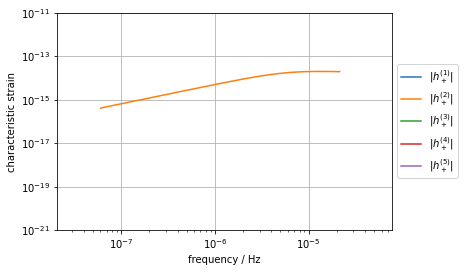

In [57]:
# Plot the first five harmonics
n_comp = 5

wfs = [SMBHBpy.waveform.h_n(n, sp, ev_ecc, acc=1e-13) for n in range(1, n_comp+1)]

for i in range(len(wfs)):
    plt.loglog(wfs[i][0]/c.hz_to_invpc, 2.*wfs[i][0]*np.abs(wfs[i][1]), label=r"$|h^{(" + str(i+1) + ")}_+|$")
    
plt.grid(); plt.xlabel("frequency / Hz"); plt.ylabel("characteristic strain"); plt.ylim(bottom=1e-21, top=1e-11)

# LISA:    
#Lisa = SMBHBpy.detector.Lisa()
#f_gw = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 100)
#plt.loglog(f_gw/c.hz_to_invpc, Lisa.NoiseStrain(f_gw), label='LISA')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)); plt.show()